In [124]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time

In [125]:
lambda_2 = 1.35e7  # Па
mu_2 = 0.9e7  # Па
gamma_m = 1.05e4  # Па/м
l = 1  # м
a2 = (gamma_m * l) / (lambda_2 + 2 * mu_2)

In [126]:
def u(x, a2):
    return (a2 / 2) * x * (x - 1)

In [127]:
x_values = np.linspace(0, 1, 10000)
u_values = u(x_values, a2)

In [128]:
train_size = int(0.7 * len(x_values))
indices = np.random.permutation(len(x_values))
train_idx, test_idx = indices[:train_size], indices[train_size:]

x_train, u_train = x_values[train_idx], u_values[train_idx]
x_test = x_values[test_idx]

In [129]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x_train_t = torch.tensor(x_train, dtype=torch.float32, device=device).view(-1, 1)
u_train_t = torch.tensor(u_train, dtype=torch.float32, device=device).view(-1, 1)
x_test_t = torch.tensor(x_test, dtype=torch.float32, device=device).view(-1, 1)

In [130]:
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )
    
    def forward(self, x):
        return self.net(x)

In [131]:
model = PINN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

In [132]:
start_time = time.time()
num_epochs = 10000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    # Втрата на основі навчальних даних
    u_pred = model(x_train_t)
    data_loss = loss_fn(u_pred, u_train_t)
    
    # Фізична втрата
    x_physics = torch.cat([x_train_t, x_test_t], dim=0).requires_grad_(True)
    u_physics = model(x_physics)
    du_dx = torch.autograd.grad(u_physics, x_physics, torch.ones_like(u_physics), create_graph=True)[0]
    d2u_dx2 = torch.autograd.grad(du_dx, x_physics, torch.ones_like(du_dx), create_graph=True)[0]
    physics_loss = loss_fn(d2u_dx2, torch.full_like(d2u_dx2, a2))
    
    loss = data_loss + physics_loss
    loss.backward()
    optimizer.step()
    
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

training_time = time.time() - start_time

Epoch 0, Loss: 0.002479
Epoch 1000, Loss: 0.000000
Epoch 2000, Loss: 0.000000
Epoch 3000, Loss: 0.000000
Epoch 4000, Loss: 0.000000
Epoch 5000, Loss: 0.000000
Epoch 6000, Loss: 0.000000
Epoch 7000, Loss: 0.000000
Epoch 8000, Loss: 0.000000
Epoch 9000, Loss: 0.000000


In [133]:
u_pred_train = model(x_train_t).detach().cpu().numpy()
u_pred_test = model(x_test_t).detach().cpu().numpy()

In [134]:
sorted_test_indices = np.argsort(x_test)
x_test = x_test[sorted_test_indices]
u_pred_test = u_pred_test[sorted_test_indices]

In [135]:
u_actual_test = u(x_test, a2)

In [136]:
print(f"Training completed in {training_time:.2f} seconds")
print(f"device used {device}")

Training completed in 40.97 seconds
device used cuda


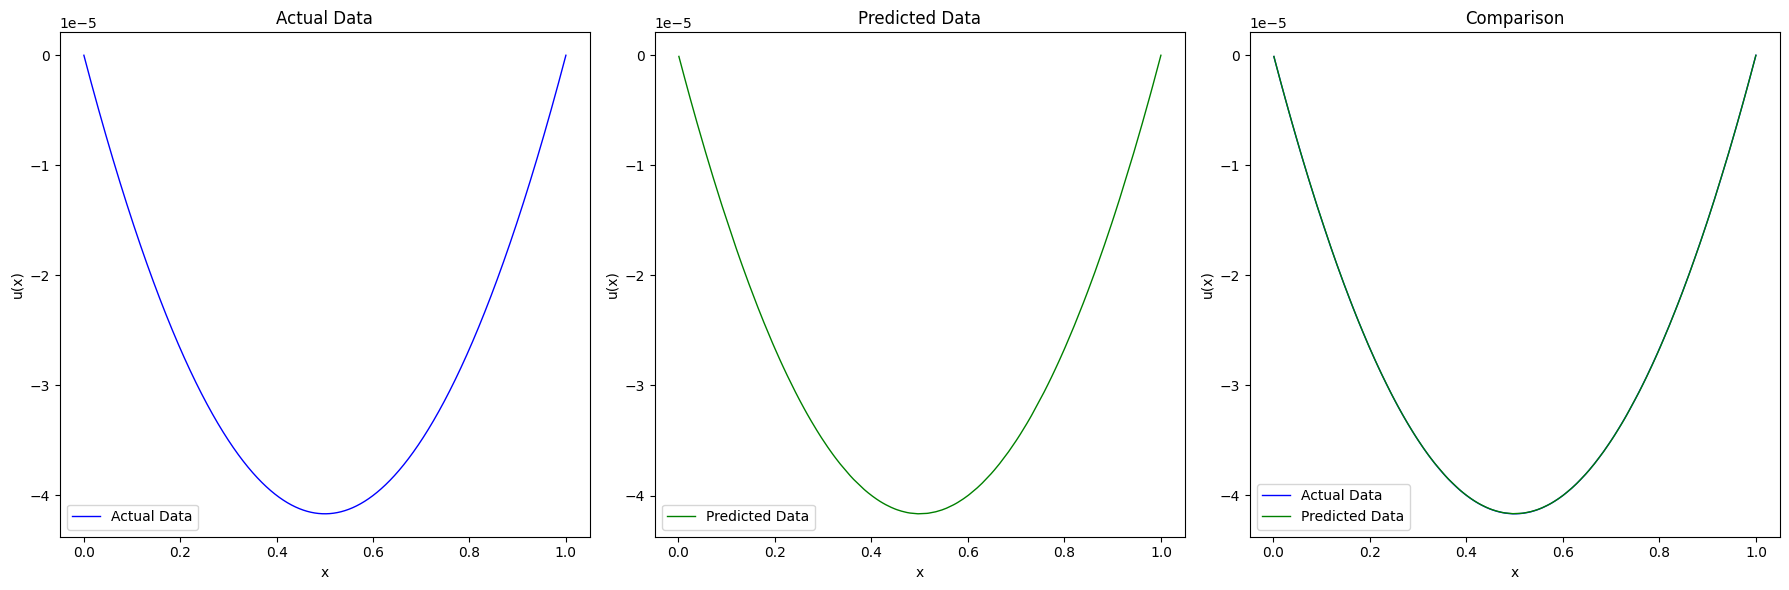

In [152]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.plot(x_values, u_values, label="Actual Data", color='blue', linewidth=1)
plt.xlabel("x")
plt.ylabel("u(x)")
plt.title("Actual Data")
plt.legend()

# 2. Графік передбачених даних
plt.subplot(1, 3, 2)
plt.plot(x_test, u_pred_test, label="Predicted Data", color='green', linewidth=1)
plt.xlabel("x")
plt.ylabel("u(x)")
plt.title("Predicted Data")
plt.legend()

# 3. Порівняння актуальних та передбачених даних
plt.subplot(1, 3, 3)
plt.plot(x_test, u_actual_test, label="Actual Data", color='blue', linewidth=1)
plt.plot(x_test, u_pred_test, label="Predicted Data", color='green', linewidth=1)
plt.xlabel("x")
plt.ylabel("u(x)")
plt.title("Comparison")
plt.legend()

plt.tight_layout()
plt.show()

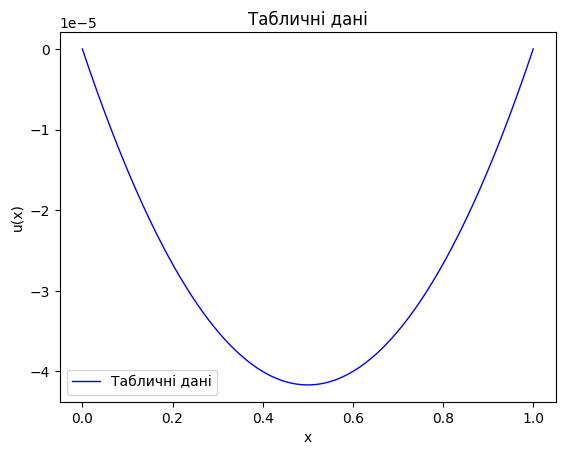

In [148]:
plt.plot(x_values, u_values, label="Табличні дані", color='blue', linewidth=1)
plt.xlabel("x")
plt.ylabel("u(x)")
plt.title("Табличні дані")
plt.legend()

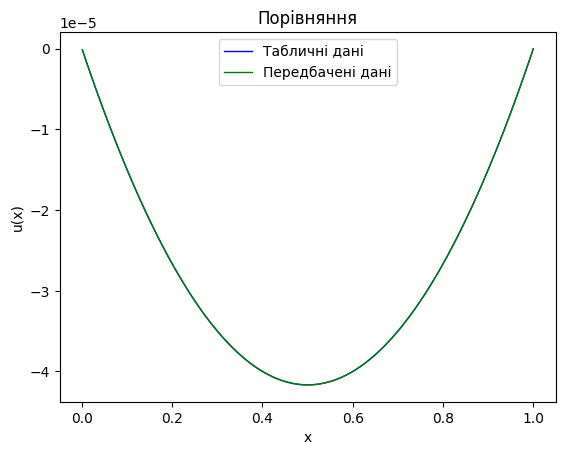

In [150]:
plt.plot(x_test, u_actual_test, label="Табличні дані", color='blue', linewidth=1)
plt.plot(x_test, u_pred_test, label="Передбачені дані", color='green', linewidth=1)
plt.xlabel("x")
plt.ylabel("u(x)")
plt.title("Порівняння")
plt.legend()

In [143]:
#torch.save(model.state_dict(), "pinn_model_task_1.pth")

In [141]:
print(u_pred_test)

[[-1.2479722e-07]
 [-2.7567148e-07]
 [-2.9057264e-07]
 ...
 [-5.4016709e-08]
 [-3.8184226e-08]
 [-1.9557774e-08]]


In [142]:
print(u_values)

[-0.00000000e+00 -1.66666665e-08 -3.33299990e-08 ... -3.33299990e-08
 -1.66666665e-08  0.00000000e+00]
